# Predicting Success: Machine Learning Models for CBT Therapy Outcomes

# 1. Introduction

This study aims to utilise machine learning techniques to predict the likelihood of success in Cognitive Behavioral Therapy (CBT) using data. The dataset encompasses various demographic, treatment-related, and psychological assessment variables, offering insights into patient profiles and treatment outcomes.  By leveraging various analytical skills, predictive models will aid in revealing the success probability for CBT in individual patients.

# 2. Explanatory Data Analysis

## 2.1 Overview

First load in the appropriate packages for EDA. Access the google drive folder, save the data in the folder ready to access. Load in the data.

In [211]:
# EDA packages
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# access google drive folder
drive.mount("/content/drive")

# load data
raw_df = pd.read_csv("/content/drive/MyDrive/Data/Dissertation_Data/mental_health.csv", delimiter = ",") # csv
df = raw_df

# set seed
#np.random.seed(2001)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now data is loaded in, check its contents and structure.

In [212]:
# data sample
raw_df.head(3)

,Unnamed: 0,IAPTus_Num,Referral Date,Age_ReferralRequest_ReceivedDate,EthnicDescGroupCode,EthnicCategoryGroupShortCode,GenderIdentity,SexualOrientationDesc,EndDesc,EndDescGroupShort,...,Item216,Item217,Item218,Item219,Item220,Item221,Item222,Item223,Item224,Item225
0,1,24475,08/09/2018,5.099020,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,24476_1,10/04/2019,4.358899,1.0,1.0,2,NaN,Mutually agreed completion of treatment,Seen and treated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,24476_2,28/03/2021,4.582576,1.0,1.0,2,NaN,Termition of treatment earlier than Care Profe...,Seen and treated,...,0,0,1,1,1,0,0,0,0,0


In [213]:
# data information
print('Data information:\n')
print('Number of rows:', raw_df.shape[0])
print('Number of columns:', raw_df.shape[1])
print('Type:', type(raw_df))

Data information:

Number of rows: 728
Number of columns: 279
Type: <class 'pandas.core.frame.DataFrame'>


**Data Content**
- Range of data types, numerical, categorical, nominal, ...
- Possibily Standardised variables (age)
- Some variables are very sparse, check this
- Check for standard things, e.g outliers, ...

**Data Structure**
- Not many entries, only 728
- A lot of variables, 279
- Perform feature selection, reduce number of variables

## 2.2 Demographic Data Preprocessing



### Overview

The first 21 variables are prodominantly demogrpahics and details on the patients, whereas the rest are answers to a questionaire. Focusing on these variables first.

In [214]:
# rename columns
df.rename(columns = {
    'Unnamed: 0': 'CaseID',
    'IAPTus_Num': 'ClientID',
    'Referral Date': 'ReferralDate',
    'Age_ReferralRequest_ReceivedDate': 'AgeAtReferralRequest',
    'EthnicDescGroupCode': 'EthnicCode',
    'EthnicCategoryGroupShortCode': 'EthnicCodeShort',
    'GenderIdentity': 'Gender',
    'SexualOrientationDesc': 'SexualOrientation',
    'EndDescGroupShort': 'Treated',
    'AllocatedCareProfNameCode': 'TherapistID',
    'JobTitleCode': 'ExperienceLevel',
    'Days to first assessment': 'DaystoAssessment',
    'Days to first treatment': 'DaystoTreatment',
    'CountOfAttendedCareContacts': 'CareContacts',
    'RecoveryDesc': 'Recovery',
    'ReliableRecoveryDesc': 'ReliableRecovery',
    'Date': 'DateOfQuestionnaire'},
    inplace = True)

In [215]:
# variable names and types
print('Column names and types:')
df.iloc[:, 0:20].dtypes

Column names and types:


CaseID                    int64
ClientID                 object
ReferralDate             object
AgeAtReferralRequest    float64
EthnicCode              float64
EthnicCodeShort         float64
Gender                   object
SexualOrientation       float64
EndDesc                  object
Treated                  object
TherapistID             float64
ExperienceLevel         float64
DaystoAssessment        float64
DaystoTreatment         float64
CareContacts            float64
ReliableChangeDesc       object
Recovery                 object
ReliableRecovery         object
EndDescShort             object
DateOfQuestionnaire      object
dtype: object

### Numerical Data

In [216]:
# create ReferralCount
def count_referrals(col):
    if '_1' in col:
        return 1
    elif '_2' in col:
        return 2
    elif '_3' in col:
        return 3
    else:
        return 1
df.insert(2, "ReferralCount", df['ClientID'].apply(count_referrals)) # introduce next to ClientID

# adjust ClientID
for text in ['_1', '_2', '_3', '_4']:
    df['ClientID'] = df['ClientID'].str.replace(text, '') # remove ending
df['ClientID'] = pd.to_numeric(df['ClientID'])

# convert to datetime
df['ReferralDate'] = pd.to_datetime(df['ReferralDate'], format = '%d/%m/%Y')
df['DateOfQuestionnaire'] = pd.to_datetime(df['DateOfQuestionnaire'], format = '%d/%m/%Y')

# convert float to integers
df['EthnicCode'] = df['EthnicCode'].astype('Int64') # Int deals with NaNs, int does not
df['EthnicCodeShort'] = df['EthnicCodeShort'].astype('Int64')
df['TherapistID'] = df['TherapistID'].astype('Int64')
df['ExperienceLevel'] = df['ExperienceLevel'].astype('Int64')

### Categorical Data

Organising categorical data, viewing the contents of the categorical data, i.e object data, first.

In [217]:
# select object data
object_vars = df.iloc[:, 0:20].select_dtypes(include = ['object'])

# unique values in categorical data
for var in object_vars:
    unique_vals = df[var].unique()
    print(var)
    print(unique_vals)
    print()

Gender
['2' '1' 'CHANGE ME' 'X' nan]

EndDesc
['Mutually agreed completion of treatment'
 'Termition of treatment earlier than Care Professiol planned'
 'Not suitable for IAPT service - no action taken or directed back to referrer'
 nan 'Referred to another therapy service by mutual agreement']

Treated
['Seen and treated' 'Seen but not treated' nan]

ReliableChangeDesc
['Reliable improvement' 'No reliable change' 'Not applicable'
 'Reliable deterioration' nan]

Recovery
['At recovery' 'Not at recovery' 'Not applicable' nan]

ReliableRecovery
['Reliable recovery' 'No reliable recovery' 'Not applicable' nan]

EndDescShort
['Completed' 'Ended before care professiol planned' 'Not suitable' nan
 'Referred elsewhere']



In [218]:
# GenderIdentity
Gender_map = {
    'CHANGE ME': np.nan,
    'X': np.nan}
df['Gender'] = df['Gender'].replace(Gender_map).astype('Int64')

# Treated
Treated_map = {
    'Seen and treated': 1,
    'Seen but not treated': 0}
df['Treated'] = df['Treated'].replace(Treated_map).astype('Int64')

# ReliableChangeDesc (-1, 0, 1)
ReliableChangeDesc_map = {
    'Reliable improvement': 2,
    'No reliable change': 1,
    'Reliable deterioration': 0,
    'Not applicable': np.nan}
df['ReliableChangeDesc'] = df['ReliableChangeDesc'].replace(ReliableChangeDesc_map).astype('Int64')

# Recovery
Recovery_map = {
    'At recovery': 1,
    'Not at recovery': 0,
    'Not applicable': np.nan}
df['Recovery'] = df['Recovery'].replace(Recovery_map).astype('Int64')

# ReliableRecovery
ReliableRecovery_map = {
    'Reliable recovery': 1,
    'No reliable recovery': 0,
    'Not applicable': np.nan}
df['ReliableRecovery'] = df['ReliableRecovery'].replace(ReliableRecovery_map).astype('Int64')

# EndDesc (onehotencode)
EndDesc_cols = pd.get_dummies(df['EndDesc'], prefix = 'EndDesc')
EndDesc_index = df.columns.get_loc('EndDesc')
df = pd.concat([df.iloc[:, :EndDesc_index + 1], EndDesc_cols, df.iloc[:, EndDesc_index + 1:]], axis = 1)

# EndDescShort (onehotencode)
EndDescShort_cols = pd.get_dummies(df['EndDescShort'], prefix = 'EndDescShort')
EndDescShort_index = df.columns.get_loc('EndDescShort')
df = pd.concat([df.iloc[:, :EndDescShort_index + 1], EndDescShort_cols, df.iloc[:, EndDescShort_index + 1:]], axis = 1)

### Review

In [219]:
# variable names and types
print('Column names and types:')
df.iloc[:, 0:28].dtypes

Column names and types:


CaseID                                                                                           int64
ClientID                                                                                         int64
ReferralCount                                                                                    int64
ReferralDate                                                                            datetime64[ns]
AgeAtReferralRequest                                                                           float64
EthnicCode                                                                                       Int64
EthnicCodeShort                                                                                  Int64
Gender                                                                                           Int64
SexualOrientation                                                                              float64
EndDesc                                                                  

In [220]:
# data sample
raw_df.iloc[:, 0:21].head(3)

,CaseID,ClientID,ReferralCount,ReferralDate,AgeAtReferralRequest,EthnicCode,EthnicCodeShort,Gender,SexualOrientation,EndDesc,...,TherapistID,ExperienceLevel,DaystoAssessment,DaystoTreatment,CareContacts,ReliableChangeDesc,Recovery,ReliableRecovery,EndDescShort,DateOfQuestionnaire
0,1,24475,1,2018-09-08,5.099020,1,1,2,NaN,Mutually agreed completion of treatment,...,1,1,NaN,131.0,53.0,2,1,1,Completed,NaT
1,2,24476,1,2019-04-10,4.358899,1,1,2,NaN,Mutually agreed completion of treatment,...,2,2,62.0,125.0,20.0,1,0,0,Completed,NaT
2,3,24476,2,2021-03-28,4.582576,1,1,2,NaN,Termition of treatment earlier than Care Profe...,...,3,3,8.0,50.0,12.0,2,1,1,Ended before care professiol planned,2021-04-04


In [221]:
# data sample
df.iloc[:, 0:28].head(3)

,CaseID,ClientID,ReferralCount,ReferralDate,AgeAtReferralRequest,EthnicCode,EthnicCodeShort,Gender,SexualOrientation,EndDesc,...,DaystoTreatment,CareContacts,ReliableChangeDesc,Recovery,ReliableRecovery,EndDescShort,EndDescShort_Completed,EndDescShort_Ended before care professiol planned,EndDescShort_Not suitable,EndDescShort_Referred elsewhere
0,1,24475,1,2018-09-08,5.099020,1,1,2,NaN,Mutually agreed completion of treatment,...,131.0,53.0,2,1,1,Completed,True,False,False,False
1,2,24476,1,2019-04-10,4.358899,1,1,2,NaN,Mutually agreed completion of treatment,...,125.0,20.0,1,0,0,Completed,True,False,False,False
2,3,24476,2,2021-03-28,4.582576,1,1,2,NaN,Termition of treatment earlier than Care Profe...,...,50.0,12.0,2,1,1,Ended before care professiol planned,False,True,False,False


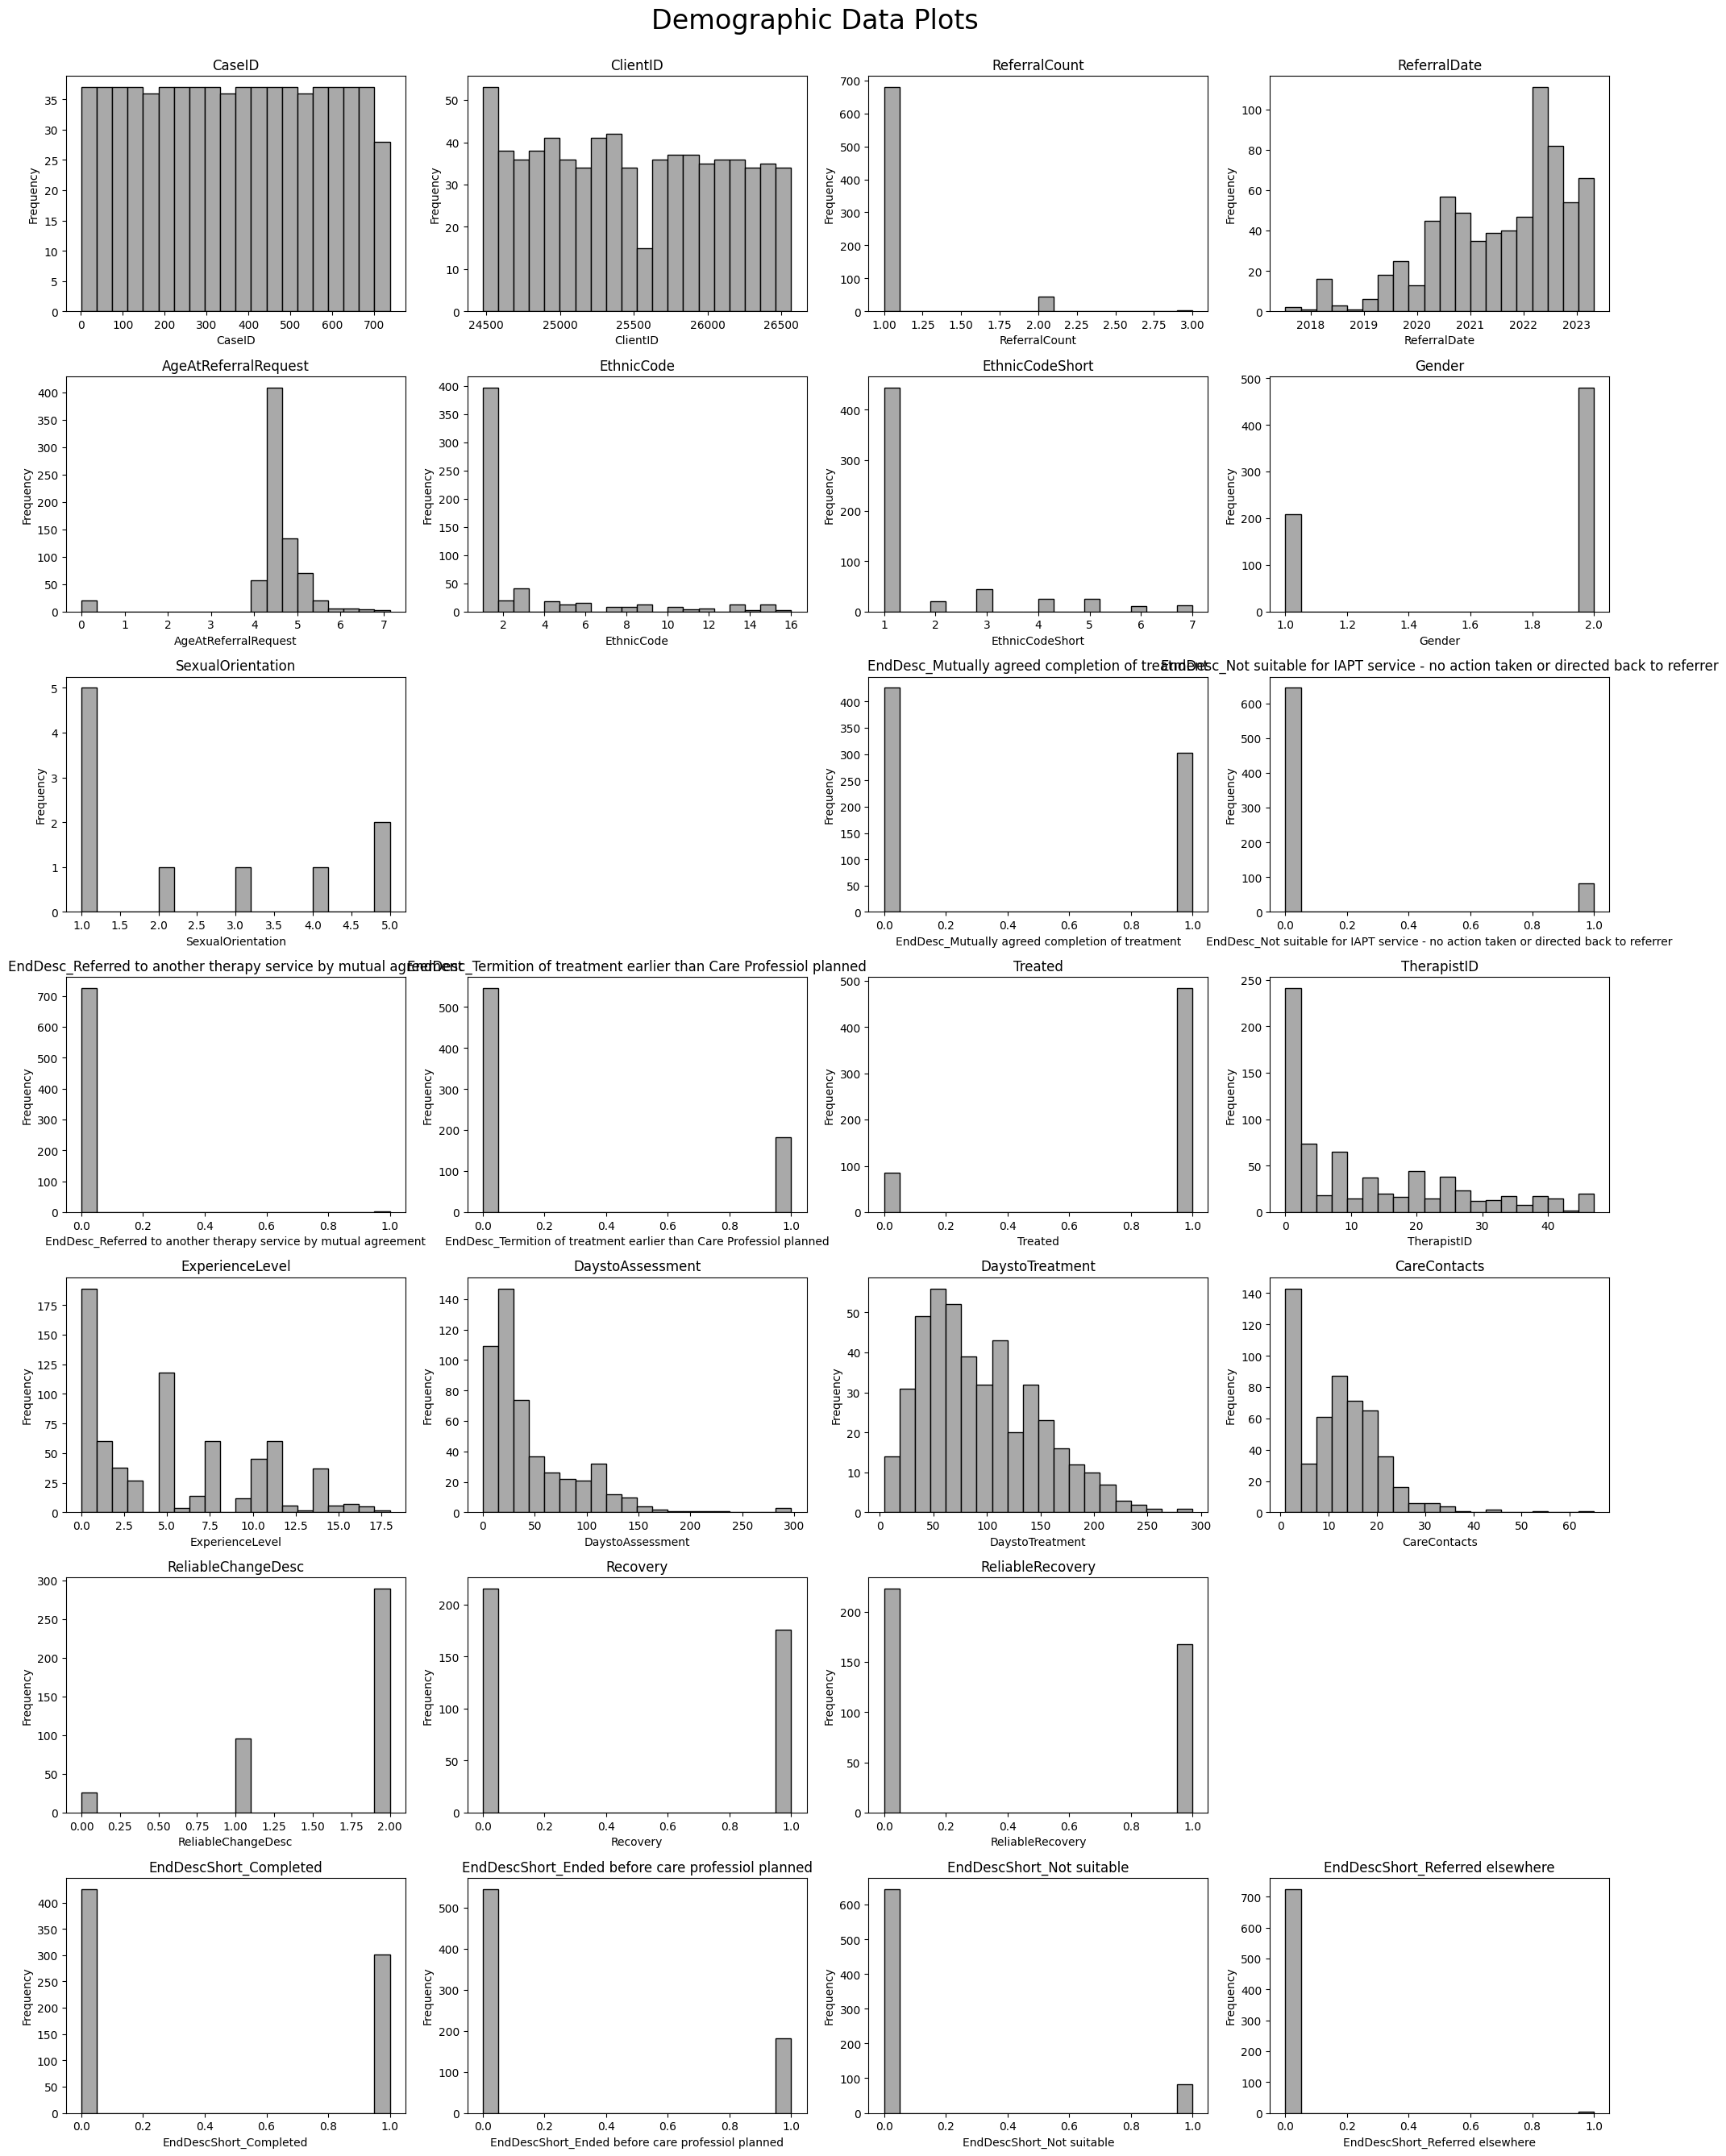

In [222]:
# figure size
plt.figure(figsize = (20, 30))

# histograms of variables
demo_df = df.iloc[:, 0:28]
dem_plots_cols = len(demo_df.columns)
dem_plots_rows = (dem_plots_cols // 4) + 1
for i, col in enumerate(demo_df.columns, start = 1):
    if demo_df[col].dtype in ['int64', 'float64', 'Int64', 'datetime64[ns]', 'bool']:
        data = demo_df[col].dropna()
        if demo_df[col].dtype == 'bool':  # convert boolean to integers
            data = data.astype(int)
        plt.subplot(dem_plots_rows, 4, i)
        plt.hist(data, bins = 20, color='darkgrey', edgecolor='black')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Frequency')

plt.suptitle('Demographic Data Plots', y = 1, fontsize = 24)
plt.tight_layout()
plt.show()

## 2.3 Questionaire Data Preprocessing (Incomplete)

In [223]:
# questionnaire data
df.iloc[:, 29:].head()

,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8,Item9,Item10,...,Item216,Item217,Item218,Item219,Item220,Item221,Item222,Item223,Item224,Item225
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,1,0,0,0,0,0
3,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- seems to be 0, 1 or NaN

In [207]:
# select object data
object_vars2 = df.iloc[:, 29:].select_dtypes(include = ['object'])

# unique values
lines_code = 5
for var in object_vars2.iloc[:, :lines_code]:
    unique_vals = df[var].unique()
    print(var)
    print(unique_vals)
    print()

Item126
['.' '2' '4' nan '3' '5' '1']

Item127
['.' '2' '3' nan '4' '5' '1']

Item128
['.' '4' nan '1' '2' '3' '5']

Item129
['.' '4' nan '1' '2' '3' '5']

Item130
['.' '4' nan '1' '2' '3']



- change '.' to NaN
- some variables maybe useless. find which are and remove them before looking at others

In [209]:
# convert '.' to NaN
df.iloc[:, 29:] = df.iloc[:, 29:].replace('.', np.nan) # might not need with to_numeric

In [224]:
# convert all variables to Int64
for col in df.columns[29:]:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')
    #df[col] = df[col].astype('Int64')

**Old**

In [ ]:
df.iloc[:, 29:].dtypes.unique()

object_indices = df.iloc[:, 29:].columns[df.iloc[:, 29:].dtypes == 'O']
float_indices = df.iloc[:, 29:].columns[df.iloc[:, 29:].dtypes == 'float64']
float_indices

# Convert columns to Int64
#df.iloc[:, 29:] = df.iloc[:, 29:].apply(pd.to_numeric, errors='coerce', downcast='integer')
non_numeric_values = df.iloc[:, 29][df.iloc[:, 29].apply(lambda x: not pd.api.types.is_numeric_dtype(x))]
nan_count = df.iloc[:, 29].isna().sum()
nan_count
# remove any values contain 22, 88, 888

# select object data
object_vars2 = df.iloc[:, 29:].select_dtypes(include = ['object'])

# unique values
for var in object_vars2:
    unique_vals = df[var].unique()
    print(var)
    print(unique_vals)
    print()

print(df.iloc[:, 29:].dtypes)

df.iloc[:, 29:]

# Check which columns from index 20 to the end are not of type float64
non_float_cols = raw_df.iloc[:, 20:].select_dtypes(exclude=['float64']).columns

if len(non_float_cols) == 0:
    print("All columns from index 20 to the end are of type float64.")
else:
    print("Columns from index 20 to the end that are not of type float64:")
    print(non_float_cols)

# 3. Data Preparation

## 3.1 Overview

In [227]:
# preparation packages
from sklearn.impute import KNNImputer

Preparation Tasks:
- Outliers
- Missing Values
- Standardisation

## 3.2 Missing Data within Rows

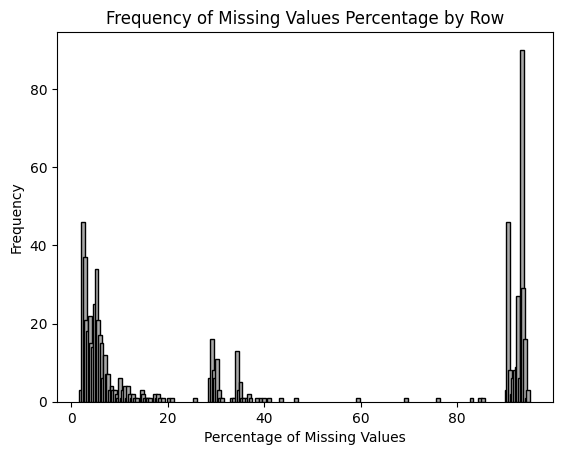

In [228]:
# calc percentage of missing values
total_cols = len(df.columns)
missing_values_by_row = df.isnull().sum(axis = 1)
percentage_missing_by_row = (missing_values_by_row / total_cols) * 100
percentage_value_counts = percentage_missing_by_row.value_counts().sort_index()

# bar chart of frequency of missing values percentage
plt.bar(percentage_value_counts.index, percentage_value_counts.values, color = 'darkgrey', edgecolor = 'black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.title('Frequency of Missing Values Percentage by Row')
plt.show()

The aim is to retain as much data as possible, especially since there is not a lot as it is. Luckily non seem to exceed 70%, very few above 50%. It would be best not to remove anything at this point.

## 3.3 Outliers (Incomplete)

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

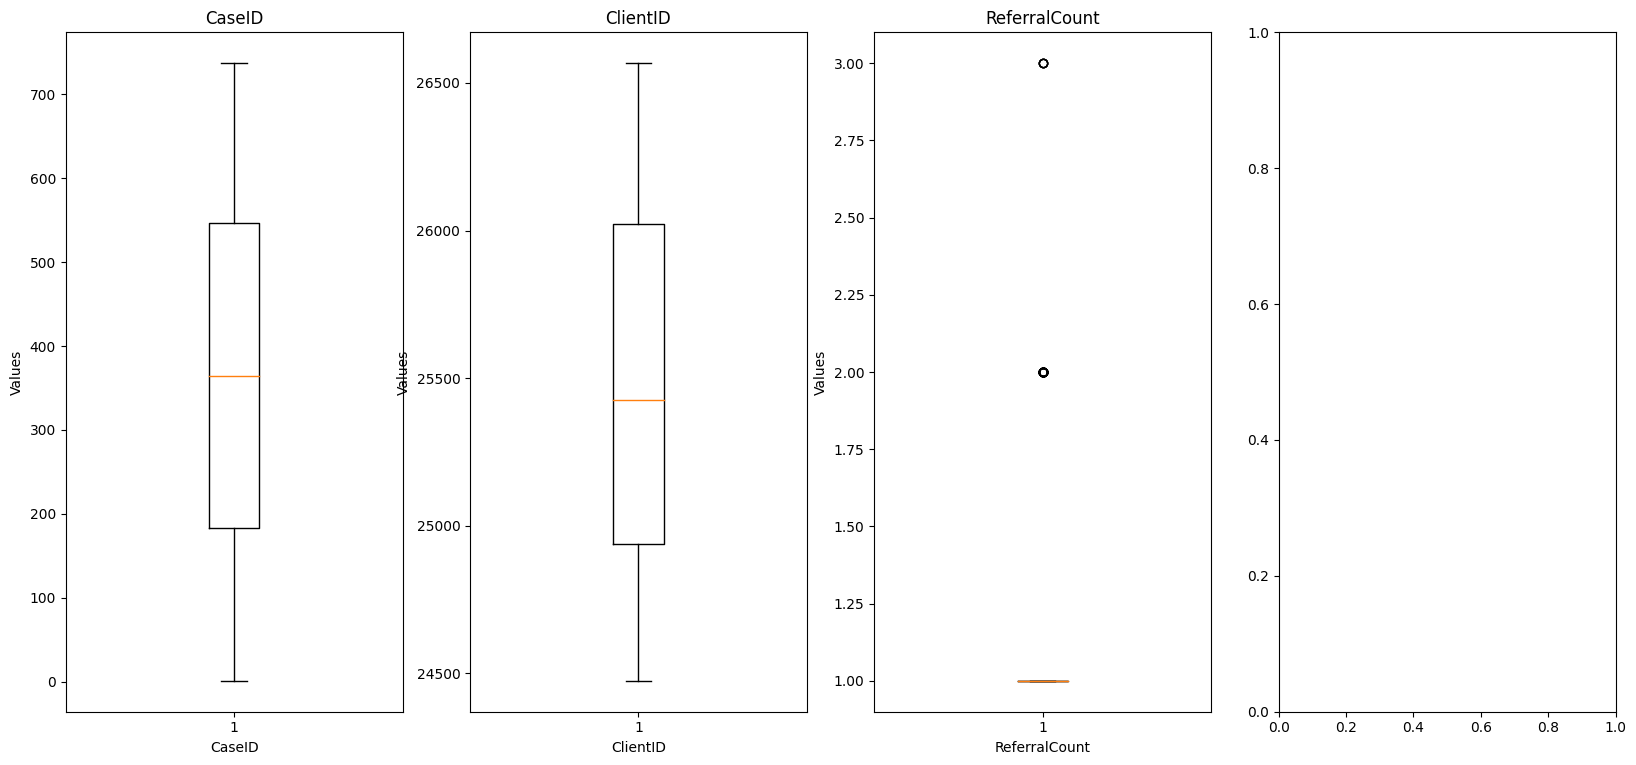

In [32]:
# Define outlier columns
outlier_cols = [
    'CaseID',
    'ClientID',
    'ReferralCount',
    'ReferralDate',
    'AgeAtReferralRequest',
    'Treated',
    'DaystoAssessment',
    'DaystoTreatment',
    'CareContacts',
    'DateOfQuestionnaire'
]

# Set a fixed figure size
plt.figure(figsize=(20, 30))

# Iterate over each column in the outlier_cols list and plot a boxplot in a subplot
num_columns = len(outlier_cols)
num_rows = (num_columns // 4) + 1  # Calculate the number of rows needed
for i, column in enumerate(outlier_cols, start=1):
    if df[column].dtype in ['int64', 'float64', 'Int64', 'datetime64[ns]']:  # Check if the column contains numerical data
        data = df[column].dropna()
        if df[column].dtype == 'bool':  # Convert boolean data to integers
            data = data.astype(int)
        plt.subplot(num_rows, 4, i)
        plt.boxplot(data)
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('Values')

plt.suptitle('Outlier Columns Boxplots', y=1, fontsize=24)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## 3.4 Missing Values

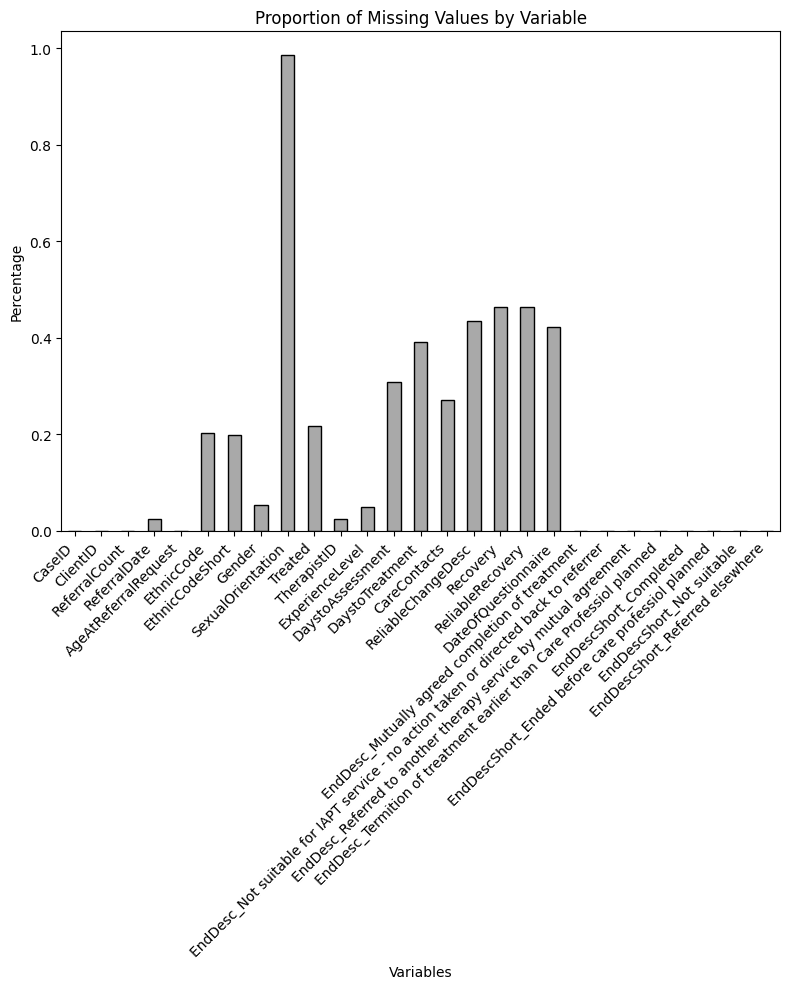

In [72]:
# number of unknowns in data
df.isna().sum() # not shown

# missing values
missing_value_percentage = df.isna().sum() / df.shape[0]
plt.figure(figsize = (8, 10))
missing_value_percentage.plot(kind = 'bar', color='darkgrey', edgecolor='black')
plt.title('Proportion of Missing Values by Variable')
plt.xlabel('Variables')
plt.ylabel('Percentage')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()

Delete Sexual Orientation, everything else ok for now.

In [73]:
# number of unknowns in data
df.isna().sum() # not shown

CaseID                                                                                    0
ClientID                                                                                  0
ReferralCount                                                                             0
ReferralDate                                                                             18
AgeAtReferralRequest                                                                      0
EthnicCode                                                                              147
EthnicCodeShort                                                                         145
Gender                                                                                   39
SexualOrientation                                                                       718
Treated                                                                                 158
TherapistID                                                                     

In [74]:
# delete SexualOrientation
df.drop(columns = ['SexualOrientation'], inplace = True)

# select missing data
missing_vals = df.isna().sum()
missing_ordered = missing_vals.sort_values() # impute variables with least missing values first
missing_ordered = missing_ordered.index.tolist()
# remove target variables
missing_ordered.remove('ReliableChangeDesc')
missing_ordered.remove('Recovery')
missing_ordered.remove('ReliableRecovery')

# impute missing values with KNN
KNN_imputer = KNNImputer(n_neighbors = 5)
for column in missing_ordered:
    if df[column].isna().sum() > 0:
        df[column] = KNN_imputer.fit_transform(df[[column]])

# 4. Modelling

## 4.1 Overview

In [90]:
# modelling packages

# machine learning models
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [91]:
# transform dataset into numerical X and y matricies (for scikit learn)
sample = df

# drop rows missing target varaible
target_var = 'ReliableRecovery'
sample = sample.dropna(subset = [target_var])

# separate explanatory and response variabels
X = sample.drop(['ReliableChangeDesc', 'ReliableRecovery', 'Recovery'], axis = 1)
y = sample['ReliableRecovery']

cols = X.columns

## 4.2 Functions

In [101]:
def XGBoost_ModelSelection(X, y, pipeline, param_grid, k = 5):

    # initialise lists
    scores = []
    #micros = []
    #macros = []
    #weighteds = []
    preds = []
    actuals = []

    # k-fold CV
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    for train_index, test_index in kf.split(X, y):

        # train and test data for CV
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # finding optimal models, hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid = param_grid, cv = kf, scoring = "f1", verbose = 0, n_jobs = -1)
        grid_search.fit(X_train, y_train)
        print("Internal CV F1 of estimator: {}".format(grid_search.best_score_))

        # number of features selected
        estimator = grid_search.best_estimator_

        # Access the SelectFromModel transformer and get the support mask
        support = estimator.named_steps['FS'].get_support()
        num_feat = np.sum(support)
        print("Number of selected features {0}".format(num_feat))

        # features selected
        col_index = np.where(support)[0]
        col_names = [cols[col] for col in col_index]
        print("Selected features {0}".format(col_names))

        # print hyperparameters selected
        print("Max depth {0}".format(estimator.named_steps["classifier"].max_depth))
        print("Number of trees {0}".format(estimator.named_steps["classifier"].n_estimators))
        print("Learning rate {0}".format(estimator.named_steps["classifier"].learning_rate))
        # additional tree specific hyperparameters
        print("Minimum child weight {0}".format(estimator.named_steps["classifier"].min_child_weight))
        print("Subsample {0}".format(estimator.named_steps["classifier"].subsample))
        print("Colsample bytree {0}".format(estimator.named_steps["classifier"].colsample_bytree))
        # additional learning specific hyperparameters
        print("Gamma {0}".format(estimator.named_steps["classifier"].gamma))
        print("Lambda {0}".format(estimator.named_steps["classifier"].reg_lambda))
        print("Alpha {0}".format(estimator.named_steps["classifier"].reg_alpha))

        # predicting the test data with the omptimised models
        predictions = estimator.predict(X_test)
        preds.extend(predictions)
        actuals.extend(y_test)
        score = metrics.f1_score(y_test,predictions)
        #micro = metrics.f1_score(y_test, predictions, average = "micro") # treats as binary
        #macro = metrics.f1_score(y_test, predictions, average = "macro") # unweighted average
        #weighted = metrics.f1_score(y_test, predictions, average = "weighted") # considers imbalance
        scores.append(score)
        #micros.append(micro)
        #macros.append(macro)
        #weighteds.append(weighted)
        print("F1 performance on this test set: {}".format(score))

        print("--------------------------------------------------")

    return scores, preds, actuals

## 4.3 XGBoost

In [104]:
# XGBoost classifier (with specific parameters)
classifier = XGBClassifier()

# feature selection with SelectFromModel
selector = SelectFromModel(classifier)

# pipeline with XGBoost and SelectFromModel
pipeline = Pipeline([("FS", selector), ("classifier", classifier)])

# hyperparameters for XGBoost and feature selector

param_grid = dict(
    FS__threshold = ["mean", "median"],
    classifier__n_estimators = [100, 200, 500],
    classifier__max_depth = [3, 5, 7],
    classifier__learning_rate = [0.01, 0.1, 0.5],
    classifier__min_child_weight = [1, 2],
    classifier__subsample = [0.5, 1.0],
    classifier__colsample_bytree = [0.5, 1.0],
    classifier__gamma = [0, 0.1],
    classifier__lambda = [0, 0.1],
    classifier__alpha = [0, 0.1])

xgb_class1 = XGBoost_ModelSelection(X, y, pipeline, param_grid, k = 5)

Internal CV F1 of estimator: 0.6498200106883344
Number of selected features 5
Selected features ['ClientID', 'ReferralCount', 'Treated', 'CareContacts', 'EndDesc_Mutually agreed completion of treatment']
Max depth 3
Number of trees 200
Learning rate 0.01
Minimum child weight 1
Subsample 1.0
Colsample bytree 1.0
Gamma 0
Lambda None
Alpha None
F1 performance on this test set: 0.6153846153846153
--------------------------------------------------
Internal CV F1 of estimator: 0.6370491260138816
Number of selected features 9
Selected features ['ReferralCount', 'ReferralDate', 'AgeAtReferralRequest', 'Gender', 'Treated', 'ExperienceLevel', 'DaystoAssessment', 'CareContacts', 'EndDesc_Mutually agreed completion of treatment']
Max depth 3
Number of trees 200
Learning rate 0.01
Minimum child weight 1
Subsample 1.0
Colsample bytree 1.0
Gamma 0
Lambda None
Alpha None
F1 performance on this test set: 0.72
--------------------------------------------------
Internal CV F1 of estimator: 0.674752879970

In [ ]:
param_grid2 = dict(
    FS__threshold = ["mean", "median"],
    classifier__n_estimators = [200, 500],
    classifier__max_depth = [3, 5],
    classifier__learning_rate = [0.01, 0.1],
    classifier__subsample = [0.5, 1.0],
    classifier__colsample_bytree = [0.5, 1.0]
)

xgb_class2 = XGBoost_ModelSelection(X, y, pipeline, param_grid2, k = 5)

Average F1 score: 0.6186020715314731
AUPRC score: 0.6953524315904851


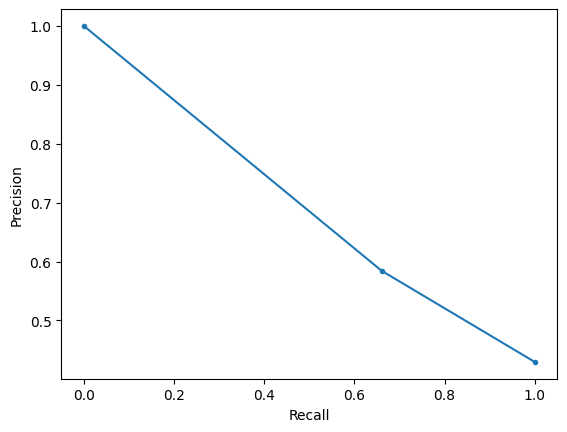

In [105]:
scores = xgb_class1[0]
preds = xgb_class1[1]
actuals = xgb_class1[2]

# Report the overall F1 score
print("Average F1 score: {0}".format(np.average(scores)))

prec, recall, _ = metrics.precision_recall_curve(actuals, preds)
print("AUPRC score: {0}".format(metrics.auc(recall, prec)))
# Generate the PR curve
plt.plot(recall, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()